# Example 03 - Official WidebandSig53 Dataset
This notebook walks through how to use `torchsig` to generate the Official WidebandSig53 Dataset.

-------------------------------------------

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%reload_ext autoreload

### Import Libraries

In [4]:
from torchsig.utils.visualize import YOLOBoundingBoxVisualizer, complex_spectrogram_to_magnitude
from torchsig.transforms import Spectrogram, Normalize, DescToBBoxYoloDict, Compose, DescToListTuple
from torchsig.datasets.wideband import WidebandModulationsDataset
from torchsig.datasets.datamodules import WidebandDataModule
from torchsig.datasets.signal_classes import torchsig_signals
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np  
import torch
from typing import List, Tuple, Any

-----------------------------
## Generate the Wideband Sig53 Dataset
To generate the WidebandSig53 dataset, several parameters are given to the imported `WidebandSig53DataModule` class. These paramters are:
- `root` ~ A string to specify the root directory of where to generate and/or read an existing WidebandSig53 dataset
- `train` ~ A boolean to specify if the WidebandSig53 dataset should be the training (True) or validation (False) sets
- `qa` - A boolean to specify whether to generate a small subset of Sig53 (True), or the full dataset (False), default is True
- `impaired` ~ A boolean to specify if the WidebandSig53 dataset should be the clean version or the impaired version
- `transform` ~ Optionally, pass in any data transforms here if the dataset will be used in an ML training pipeline. Note: these transforms are not called during the dataset generation. The static saved dataset will always be in IQ format. The transform is only called when retrieving data examples.
- `target_transform` ~ Optionally, pass in any target transforms here if the dataset will be used in an ML training pipeline. Note: these target transforms are not called during the dataset generation. The static saved dataset will always be saved as tuples in the LMDB dataset. The target transform is only called when retrieving data examples.

A combination of the `train` and the `impaired` booleans determines which of the four (4) distinct WidebandSig53 datasets will be instantiated:
| `impaired` | `qa` | Result |
| ---------- | ---- | ------- |
| `False` | `False` | Clean datasets of train=250k examples and val=25k examples |
| `False` | `True` | Clean datasets of train=250 examples and val=250 examples |
| `True` | `False` | Impaired datasets of train=250k examples and val=25k examples |
| `True` | `True` | Impaired datasets of train=250 examples and val=250 examples |

The final option of the impaired validation set is the dataset to be used when reporting any results with the official WidebandSig53 dataset.

In [5]:
# Generate WidebandSig53 DataModule
root = "../datasets"
impaired = False
qa = True
fft_size = 512
num_classes = 61
batch_size = 16
num_workers = 0

transform = Compose([                
    Spectrogram(nperseg=fft_size, noverlap=0, nfft=fft_size, mode='complex'),
    Normalize(norm=np.inf, flatten=True),
])

target_transform = Compose([
    DescToBBoxYoloDict(class_list=torchsig_signals.class_list),
])


def yolo_collate_fn(batch):
    data, labels = zip(*batch)
    data_tensor = torch.from_numpy(np.stack(data))
    label_list = np.stack(labels)
    return data_tensor, label_list

datamodule = WidebandDataModule(
    root=root,
    impaired=impaired,
    qa=qa,
    fft_size=fft_size,
    num_classes=num_classes,
    transform=transform,
    target_transform=target_transform,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=yolo_collate_fn
)

datamodule.prepare_data()
datamodule.setup("fit")


print("Testing DataLoader:")
data_loader = datamodule.train_dataloader()

# Force iteration
batch = next(iter(data_loader))
print(batch)
print(type(batch[0]))
print(f"Batch data shape: {batch[0].shape}")
print(f"IQ data shape: {batch[0][0].shape}")
print(f"Len labels: {len(batch[1])}")

Using WidebandCleanTrainQAConfig for train.
Dataset already exists in ../datasets/wideband_clean_train. Not regenerating
Using WidebandCleanValQAConfig for val.
Dataset already exists in ../datasets/wideband_clean_val. Not regenerating
Testing DataLoader:
(tensor([[[[ 4.5613e-04, -3.9576e-03,  1.4002e-03,  ...,  7.7248e-03,
           -1.3876e-03,  4.7802e-05],
          [-1.0036e-02,  7.7754e-03,  7.5903e-03,  ..., -5.5887e-03,
           -2.7729e-03,  2.3505e-03],
          [ 1.0490e-02, -6.6254e-03, -1.1154e-02,  ..., -5.4274e-04,
            5.8380e-03, -2.3969e-03],
          ...,
          [-2.2955e-03, -2.3300e-03,  4.2844e-04,  ..., -4.0062e-03,
            2.9030e-04,  8.7032e-03],
          [-3.6595e-03,  4.6413e-04,  3.8160e-03,  ...,  4.4975e-03,
           -6.1646e-04, -5.7686e-03],
          [ 6.4042e-03,  9.0886e-04, -6.3046e-03,  ..., -5.5450e-03,
            2.6260e-03,  8.8724e-04]],

         [[ 4.9341e-03,  5.5482e-03, -9.6266e-04,  ...,  8.0335e-03,
           -3.3

### Plot Subset to Verify
The `MaskClassVisualizer` can be passed a `Dataloader` and plot visualizations of the dataset. The `batch_size` of the `DataLoader` determines how many examples to plot for each iteration over the visualizer. Note that the dataset itself can be indexed and plotted sequentially using any familiar python plotting tools as an alternative plotting method to using the `spdata` `Visualizer` as shown below.

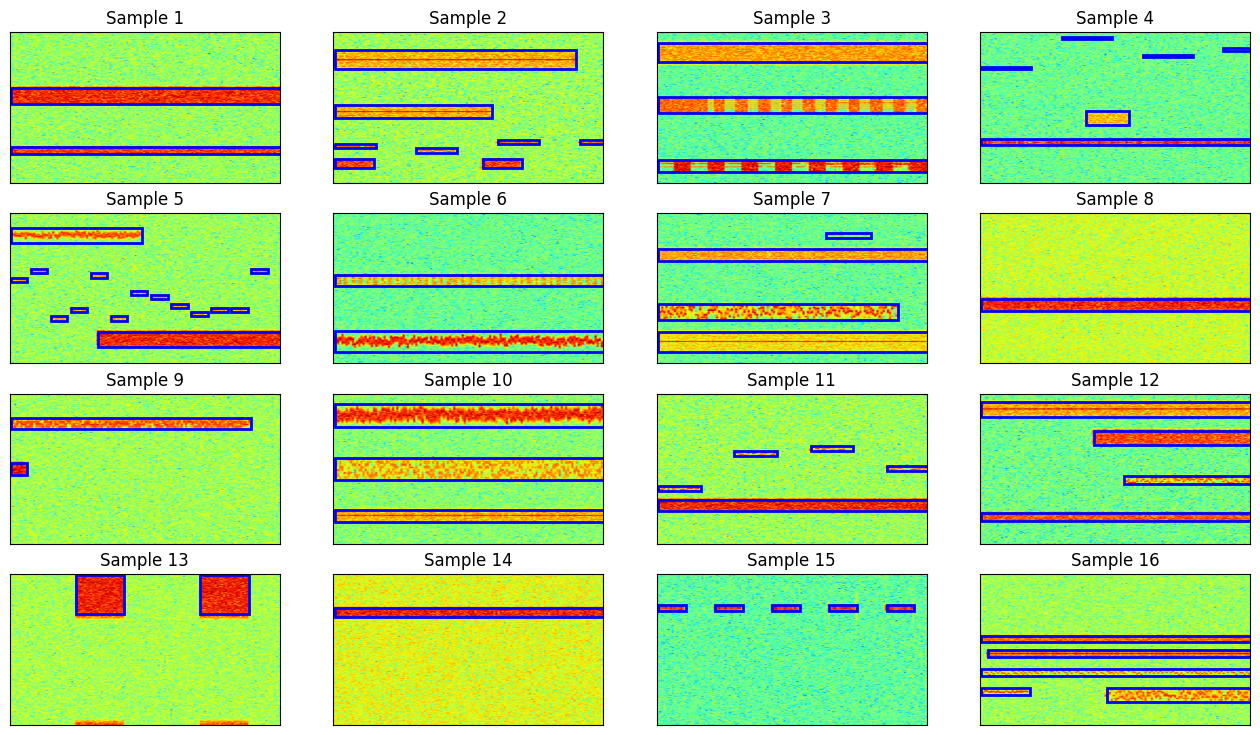

In [6]:
data_loader = datamodule.train_dataloader()

visualizer = YOLOBoundingBoxVisualizer(
    data_loader=data_loader,
    visualize_transform=complex_spectrogram_to_magnitude,
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 9)
    plt.show()
    break

----
### Analyze Dataset
The dataset can also be analyzed at the macro level for details such as the distribution of classes and number of signals per sample. The below analysis reads information directly from the non-target transformed tuple annotations. Since this is different than the above dataset instantiation, the dataset is re-instantiated for analysis.

In [23]:
# Re-instantiate the WidebandSig53 Dataset witbatch_size=1, num_workers=1, hout a target transform and without using the RFData objects
datamodule = WidebandDataModule(
    root=root,
    impaired=impaired,
    qa=qa,
    fft_size=fft_size,
    num_classes=num_classes,
    transform=transform,
    target_transform=None,
    batch_size=1,
    num_workers=1
)
datamodule.prepare_data()
datamodule.setup("fit")

wideband_sig53 = datamodule.train

# Loop through the dataset recording classes and SNRs
class_counter_dict = {
    class_name: 0 for class_name in list(wideband_sig53.class_list)
}
num_signals_per_sample = []

for idx in tqdm(range(len(wideband_sig53))):
    data, annotation = wideband_sig53[idx]
    num_signals_per_sample.append(len(annotation))
    for signal_annotation in annotation:
        class_counter_dict[signal_annotation["class_name"]] += 1

Using WidebandCleanTrainQAConfig for train.
Dataset already exists in ../datasets/wideband_clean_train. Not regenerating
Using WidebandCleanValQAConfig for val.
Dataset already exists in ../datasets/wideband_clean_val. Not regenerating


100%|██████████| 100/100 [00:00<00:00, 590.07it/s]


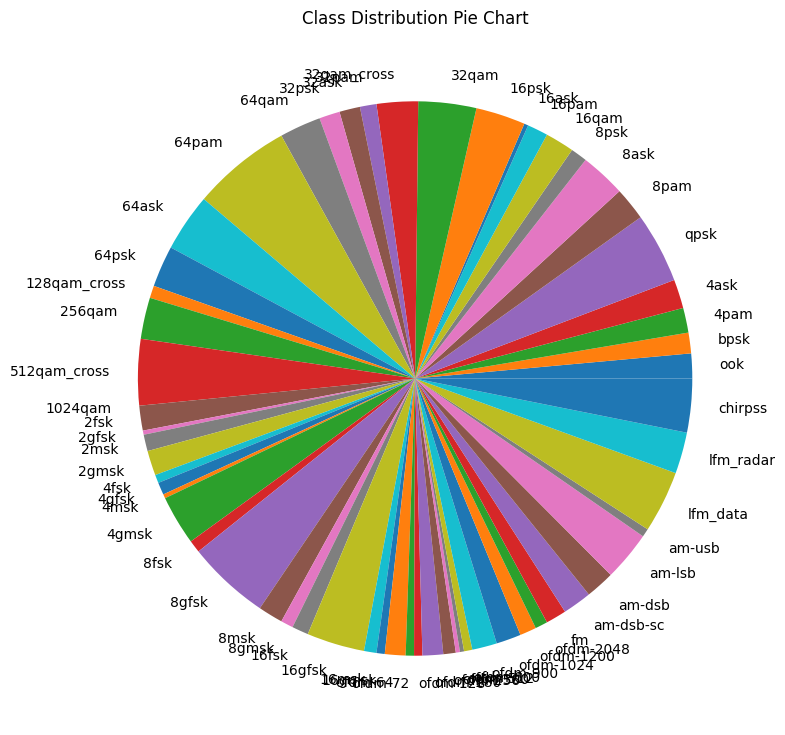

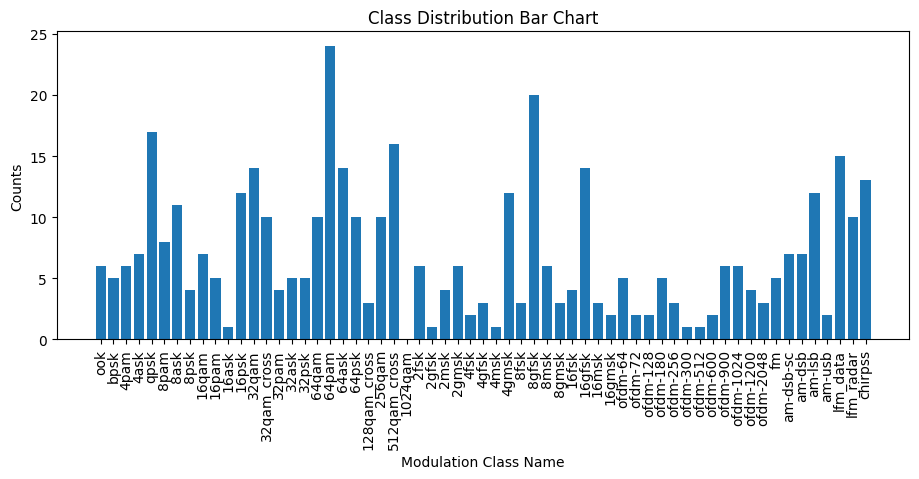

In [25]:
# Plot the distribution of classes
class_names = list(class_counter_dict.keys())
num_classes = list(class_counter_dict.values())

plt.figure(figsize=(9,9))
plt.pie(num_classes, labels=class_names)
plt.title("Class Distribution Pie Chart")
plt.show()

plt.figure(figsize=(11,4))
plt.bar(class_names, num_classes)
plt.xticks(rotation=90)
plt.title("Class Distribution Bar Chart")
plt.xlabel("Modulation Class Name")
plt.ylabel("Counts")
plt.show()

The above distribution of classes shows all OFDM signals appearing less frequently than the remaining modulations. This makes sense because OFDM signals are drawn from a random distribution of bandwidths that are inherently larger than the remaining signals, meaning fewer OFDM signals can fit into a wideband spectrum without overlapping. Additionally, the random bursty probability and durations of OFDM signals makes it less likely to occupy a wideband capture with many short-time bursts, while the remaining modulations experience this behavior at a higher probility.

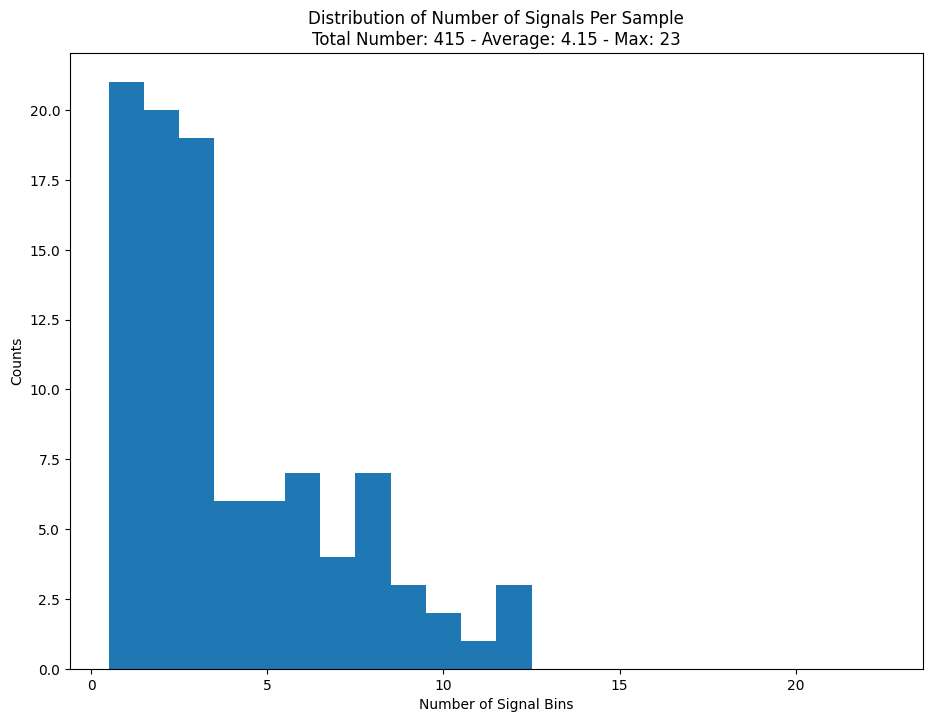

In [26]:
# Plot the distribution of number of signals per sample
plt.figure(figsize=(11,8))
plt.hist(x=num_signals_per_sample, bins=np.arange(1,max(num_signals_per_sample)+1)-0.5)
plt.title("Distribution of Number of Signals Per Sample\nTotal Number: {} - Average: {} - Max: {}".format(
    sum(num_signals_per_sample),
    np.mean(np.asarray(num_signals_per_sample)),
    max(num_signals_per_sample),
))
plt.xlabel("Number of Signal Bins")
plt.ylabel("Counts")
plt.show()

The above distribution of the number of signals per sample shows the most commonly seen sample has two signals present. The average is slightly around 4 signals per sample and the max is 26.

In [38]:
# For additional analysis, reinstantiate the dataset without a transform, such that the RFDescriptions can be read
datamodule = WidebandDataModule(
    root=root,
    impaired=impaired,
    qa=qa,
    fft_size=fft_size,
    num_classes=num_classes,
    transform=None,
    target_transform=None,
    batch_size=1,
    num_workers=1
)
datamodule.prepare_data()
datamodule.setup("fit")

wideband_sig53 =datamodule.train

num_samples = len(wideband_sig53)
snrs = []
bandwidths = []
durations = []
for idx in tqdm(range(num_samples)):
    label = wideband_sig53[idx][1]
    for meta in label:
        snrs.append(meta["snr"])
        bandwidths.append(meta["bandwidth"])
        durations.append(meta["duration"])

multiprocessing_context:  None
Using WidebandCleanTrainQAConfig for train.
Dataset already exists in ../datasets/wideband_sig53/wideband_clean_train. Not regenerating
multiprocessing_context:  None
Using WidebandCleanValQAConfig for val.
Dataset already exists in ../datasets/wideband_sig53/wideband_clean_val. Not regenerating


100%|██████████| 250/250 [00:00<00:00, 888.04it/s]


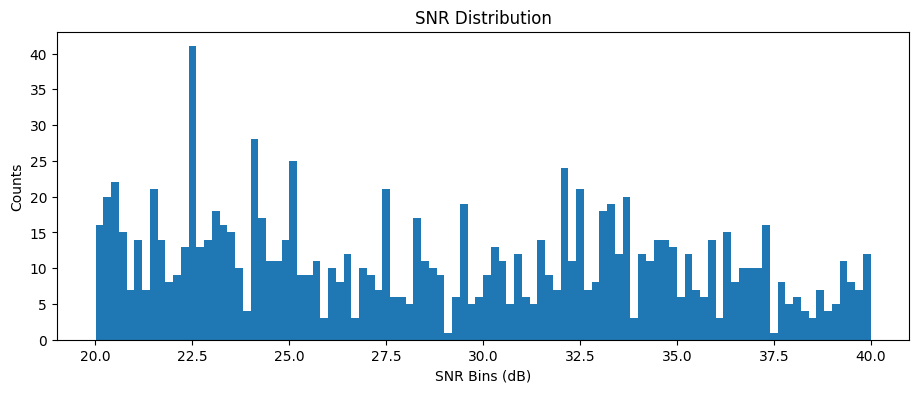

In [39]:
# Plot the distribution of SNR values
plt.figure(figsize=(11,4))
plt.hist(x=snrs, bins=100)
plt.title("SNR Distribution")
plt.xlabel("SNR Bins (dB)")
plt.ylabel("Counts")
plt.show()

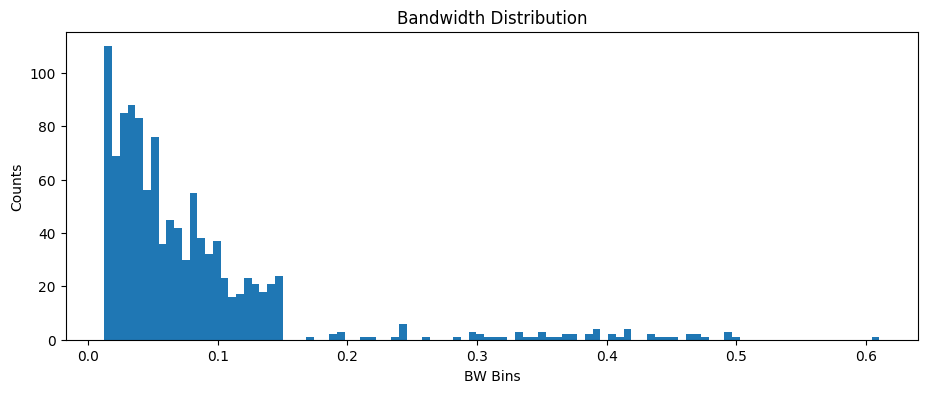

In [40]:
# Plot the distribution of bandwidth values
plt.figure(figsize=(11,4))
plt.hist(x=bandwidths, bins=100)
plt.title("Bandwidth Distribution")
plt.xlabel("BW Bins")
plt.ylabel("Counts")
plt.show()

In [ ]:
# Plot the distribution of bandwidth values
# plt.figure(figsize=(11,4))
# plt.hist(x=durations, bins=100)
# plt.title("Duration Distribution")
# plt.xlabel("Duration Bins")
# plt.ylabel("Counts")
# plt.show()